<a href="https://colab.research.google.com/github/corwindark/5000-lab-1.2/blob/main/dl_ens_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Setup - Run Every Time

In [ ]:
# TENSORFLOW
import tensorflow as tf
print("TENSORFLOW VERSION:",tf.__version__)

# PYTORCH
import torch
print("PYTORCH VERSION:",torch.__version__)

# KERAS
import keras;
print("KERAS VERSION:",keras.__version__)

TENSORFLOW VERSION: 2.15.0
PYTORCH VERSION: 2.1.0+cu121
KERAS VERSION: 2.15.0


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
# GET SYSTEM INFO
# code modified from: https://stackoverflow.com/questions/110362/how-can-i-find-the-current-os-in-python

import platform
import multiprocessing
import sys
import psutil

def linux_distribution():
  try:
    return platform.linux_distribution()
  except:
    return "N/A"

def dist():
  try:
    return platform.dist()
  except:
    return "N/A"

num_cores=multiprocessing.cpu_count()

print("""
Python version: %s
dist: %s
num_cores: %s
linux_distribution: %s
system: %s
machine: %s
platform: %s
uname: %s
version: %s
RAM: %s
""" % (
sys.version.split('\n'),
str(dist()),
num_cores,
linux_distribution(),
platform.system(),
platform.machine(),
platform.platform(),
platform.uname(),
platform.version(),
psutil.virtual_memory().total*10**(-9.)
))

# print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))


Python version: ['3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]']
dist: N/A
num_cores: 2
linux_distribution: N/A
system: Linux
machine: x86_64
platform: Linux-6.1.58+-x86_64-with-glibc2.35
uname: uname_result(system='Linux', node='c5e29aeddf60', release='6.1.58+', version='#1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023', machine='x86_64')
version: #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
RAM: 13.60945152



In [ ]:
torch.cuda.device_count()
torch.cuda.get_device_properties(0).total_memory

15835660288

In [ ]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "statsforecast"])

0

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoCES, AutoARIMA, AutoETS, DynamicOptimizedTheta
import numpy as np
import time

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Old Stat Functions

In [ ]:
def crossValidation(train, test, window, outputFrame, modelName, predReturnFunction):

    totalPredictions = pd.Series(dtype = 'float64')
    windows = len(test) // window

    predictionIndex = 0

    for i in range(0, windows):
        # debug
        #print("Window: ", i, "Method: ", modelName)

        # How many observations to move forward each frame
        addNum = i * window
        # Combine training data with additional test window
        intermediateData = pd.concat([train, test[:addNum]])
        # Generate prediction of the given window size
        prediction = predReturnFunction(intermediateData, window)
        #print(prediction)
        # Check if we have multiple predictions in the window
        if len(prediction) > 1:
            # Store each predicted value with a loop
            for j in range(0,window):

                # Store in the prediction-comparison frame
                outputFrame[modelName][predictionIndex] = prediction[j]

                # Move to next open spot
                predictionIndex += 1
        else:

            outputFrame[modelName][predictionIndex] = prediction[0]
            predictionIndex += 1


In [ ]:
def stat_test_wrapper(seriesTrain, seriesTest, testDF,  test_out_size = 100, window_size = 1):
    # Set the number of observations to be included in the test set

  testDFCopy = testDF.copy()

  tempTest = seriesTest[:test_out_size]

  # Auto Arima
  crossValidation(seriesTrain, tempTest, window_size, testDFCopy, 'auto_arima', aaPredFunction)

  crossValidation(seriesTrain, tempTest, window_size, testDFCopy, 'complex_smoothing', cesPredFunction)

  #crossValidation(seriesTrain, tempTest, window_size, testDFCopy, 'auto_ets', etsPredFunction)

  crossValidation(seriesTrain, tempTest, window_size, testDFCopy, 'dyn_theta', dotPredFunction)




  plot2 = testDFCopy.iloc[0:test_out_size,:]

  preds = plot2.loc[:,['auto_arima', 'complex_smoothing', 'dyn_theta']]
  # ensemble methods
  plot2.loc[:,'mean_ens'] = preds.mean(axis = 1)
  plot2.loc[:,'median_ens'] = preds.median(axis = 1)


  plot2.loc[:,'auto_arima'] = abs( plot2.loc[:,'auto_arima'] - plot2.loc[:,'Price'] )
  # auto ets is not very good apparently
  #plot2.loc[:,'auto_ets'] = abs( plot2.loc[:,'auto_ets'] - plot2.loc[:,'Price'] )
  plot2.loc[:,'complex_smoothing'] = abs( plot2.loc[:,'complex_smoothing'] - plot2.loc[:,'Price'] )
  plot2.loc[:,'dyn_theta'] = abs( plot2.loc[:,'dyn_theta'] - plot2.loc[:,'Price'] )
  plot2.loc[:,'mean_ens'] = abs( plot2.loc[:,'mean_ens'] - plot2.loc[:,'Price'] )
  plot2.loc[:,'median_ens'] = abs( plot2.loc[:,'median_ens'] - plot2.loc[:,'Price'] )



  # get the index as a column for plotting
  plot2 = plot2.reset_index()

  errorDat = plot2.copy()

  names = ['auto_arima', 'dyn_theta', 'complex_smoothing']
  errorDat['optimal'] = errorDat[names].idxmin(axis="columns")

  #print("reached loop")
  """
  for index in range(0, errorDat.shape[0]):
      #print(index)

      predictionErrors = errorDat.loc[index,['auto_arima', 'auto_ets', 'dyn_theta', 'complex_smoothing'] ]

      #print(predictionErrors)

      #print(min(abs(predictionErrors)))
      #errorDat.loc[index ,'optimal'] = min(abs(predictionErrors))
  """



  return testDFCopy, errorDat

In [ ]:
def aaPredFunction(dataIn, windowSize):
    model = AutoARIMA()
    fit1 = model.fit(y = np.concatenate(dataIn.to_numpy()))
    prediction = fit1.predict(h = windowSize)
    return prediction.get('mean')


def cesPredFunction(dataIn, windowSize):
    model = AutoCES()
    fit1 = model.fit(y = np.concatenate(dataIn.to_numpy()))
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

def etsPredFunction(dataIn, windowSize):
    model = AutoETS()
    fit1 = model.fit(y = np.concatenate(dataIn.to_numpy()))
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

def dotPredFunction(dataIn, windowSize):
    model = DynamicOptimizedTheta()
    fit1 = model.fit(y = np.concatenate(dataIn.to_numpy()))
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')



# Set the number of observations to be included in the test set
test_out_size = 200

tempTest = seriesTest[:test_out_size]


In [ ]:


def prep_ticker(ticker, start_date = '2022-06-01', end_date = '2023-09-30', intervals = '60m', split = True, train_size = 2000, model_list = ['auto_arima', 'dyn_theta', 'auto_ets', 'complex_smoothing']):
  data = yf.download(ticker,start_date, end_date, interval = intervals)
  #print(data.head())
  data.reset_index(inplace = True)


  data_train = data[:train_size]
  data_test = data[train_size:]

  test_size = len(data_test)


  data_test = data_test[["Datetime", "Close"]]
  data_train = data_train[["Datetime", "Close"]]

  seriesTrain = data_train.set_index('Datetime')
  seriesTest = data_test.set_index('Datetime')

  testResultsDF = pd.DataFrame(index = range(test_size))
  testResultsDF['Price'] = 0

  #print(data.head())

  # Get a clean format for close prices
  for i in range(0,test_size):
      testResultsDF['Price'][i] = seriesTest.values[i][0]


  # Initialize empty cells for the statistical forecasts
  for modeltype in model_list:
    testResultsDF[modeltype] = 0

  return testResultsDF, seriesTrain, seriesTest

# Old Stat Examples


In [ ]:

data = yf.download('SPY','2022-06-01','2023-09-30', interval ="60m")
%matplotlib inline

data['Adj Close'].plot()
plt.ion()
print(data)

data.reset_index(inplace = True)
print(data.head())

In [ ]:
train_size = 2000

data_train = data[:train_size]
data_test = data[train_size:]

test_size = len(data_test)


data_test = data_test[["Datetime", "Close"]]
data_train = data_train[["Datetime", "Close"]]

seriesTrain = data_train.set_index('Datetime')
seriesTest = data_test.set_index('Datetime')

cv_data = data[['Close']]

In [ ]:
# Let's reformat the test data into a dataframe we can add our predictions to

testResultsDF = pd.DataFrame(index = range(test_size))
testResultsDF['Price'] = 0
# Get a clean format for close prices
for i in range(0,test_size):
    testResultsDF['Price'][i] = seriesTest.values[i][0]


# Initialize empty cells for the statistical forecasts
testResultsDF['auto_arima'] = 0
testResultsDF['dyn_theta'] = 0
#testResultsDF['auto_ets'] = 0
testResultsDF['complex_smoothing'] = 0

In [ ]:

# Auto Arima
crossValidation(seriesTrain, tempTest, 1, testResultsDF, 'auto_arima', aaPredFunction)

crossValidation(seriesTrain, tempTest, 1, testResultsDF, 'complex_smoothing', cesPredFunction)

crossValidation(seriesTrain, tempTest, 1, testResultsDF, 'auto_ets', etsPredFunction)

crossValidation(seriesTrain, tempTest, 1, testResultsDF, 'dyn_theta', dotPredFunction)


In [ ]:
print(testResultsDF)

plot1 = testResultsDF.iloc[0:test_out_size,:]

# get the index as a column for plotting
plot1 = plot1.reset_index()

plot1 = pd.melt(plot1, id_vars = ['index'], value_vars =  ['auto_arima', 'auto_ets', 'complex_smoothing', 'dyn_theta', 'Price'])

print(plot1)

sns.lineplot(plot1, x = 'index', y = 'value', hue = 'variable')

In [ ]:

plot1 = testResultsDF.iloc[0:test_out_size,:]

# get the index as a column for plotting
plot1 = plot1.reset_index()

plot1 = pd.melt(plot1, id_vars = ['index'], value_vars =  ['auto_arima', 'auto_ets', 'complex_smoothing', 'dyn_theta', 'Price'])

print(plot1)

sns.lineplot(plot1, x = 'index', y = 'value', hue = 'variable')

In [ ]:
print(testResultsDF)

plot2 = testResultsDF.iloc[0:test_out_size,:]

plot2['auto_arima'] = plot2['auto_arima'] - plot2['Price']
plot2['auto_ets'] = plot2['auto_ets'] - plot2['Price']
plot2['complex_smoothing'] = plot2['complex_smoothing'] - plot2['Price']
plot2['dyn_theta'] = plot2['dyn_theta'] - plot2['Price']





# get the index as a column for plotting
plot2 = plot2.reset_index()

errorDat = plot2.copy()

plot2 = pd.melt(plot2, id_vars = ['index'], value_vars =  ['auto_arima', 'auto_ets', 'complex_smoothing', 'dyn_theta'])

sns.barplot(plot2, x = 'index', y = 'value', hue = 'variable')

In [ ]:
print(AAPLerrors.head())
print(AAPLerrors['optimal'].value_counts() )

print(AAPLerrors['auto_arima'].mean())
print(AAPLerrors['dyn_theta'].mean())
print(AAPLerrors['complex_smoothing'].mean())
print(AAPLerrors['mean_ens'].mean())

optimals = ['auto_arima', 'dyn_theta', 'complex_smoothing']
print(AAPLerrors[optimals].min(axis="columns").mean())


In [ ]:
AAPLpreds, AAPLerrors = stat_test_wrapper(trainSeriesAAPL, testSeriesAAPL, testResultsAAPL, 25, 1)


In [ ]:
errorDat['optimal'] = 0

for index in range(0, errorDat.shape[0]):
   # print(index)
    predictionErrors = errorDat.loc[:,('auto_arima', 'auto_ets', 'dyn_theta', 'complex_smoothing') ]

    #print(predictionErrors.min())

    errorDat.loc[index ,'optimal'] = min(predictionErrors)

errorDat

In [ ]:
print(qqqerrors.head())
print(qqqerrors['optimal'].value_counts() )
# QQQ, 22-6-1 to 23-9-30, 1hr,
# > 5-1 is auto_arima 4, complex smoothing 1
# > 100-1 is auto_arima 50, complex smoothing 44, dyn_theta 6
# > 200-20 is auto_arima 41, complex_smoothing 111, dyn_theta 48
# > 200-50 is auto_arima 18, c_s 92, dyn_theta 90
# > 200-100 is a_a 60, c_s 78, d_t 62
# AAPL, 22-6-1 to 23-9-30, 1hr,
# 100 - 1 is a_a 42, c_s 51, d_t 7





```
# This is formatted as code
```

# New DL Functions

In [ ]:
# Getting more different financial datasets


def prep_ticker(ticker, start_date = '2022-06-01', end_date = '2023-09-30', intervals = '60m', split = True, train_size = 2000, model_list = ['auto_arima', 'dyn_theta', 'auto_ets', 'complex_smoothing']):
  data = yf.download(ticker,start_date, end_date, interval = intervals)

  #print(data.head)

  data.reset_index(inplace = True)

  if split == True:
    data_train = data[:train_size]
    data_test = data[train_size:]

    test_size = len(data_test)


    data_test = data_test[["Datetime", "Close"]]
    data_train = data_train[["Datetime", "Close"]]

    seriesTrain = data_train.set_index('Datetime')
    seriesTest = data_test.set_index('Datetime')


    return seriesTrain, seriesTest

  elif split == False:
    data_out = data

    data_out = data_out[["Datetime", "Close"]]

    seriesOut = data_out.set_index('Datetime')


    return seriesOut




In [ ]:
def new_aaPredFunction(dataIn, windowSize):
    model = AutoARIMA()
    fit1 = model.fit(dataIn)
    prediction = fit1.predict(h = windowSize)
    return prediction.get('mean')


def new_cesPredFunction(dataIn, windowSize):
    model = AutoCES()
    fit1 = model.fit(dataIn)
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

def new_etsPredFunction(dataIn, windowSize):
    model = AutoETS()
    fit1 = model.fit(dataIn)
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

def new_dotPredFunction(dataIn, windowSize):
    model = DynamicOptimizedTheta()
    fit1 = model.fit(dataIn)
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

In [ ]:
def stat_true_window_cross_val(unsplitdata, model_names, predReturnFunctions, train_window = 10, test_window = 1):
    totalPredictions = pd.Series(dtype = 'float64')
    windows = len(unsplitdata) // (train_window + test_window)
    columns = train_window + (test_window * (1 + len(model_names)))

    pred_df = np.zeros([windows, columns])
    print(pred_df.shape)

    unsplitdata = np.array(unsplitdata)
    unsplitdata = unsplitdata.reshape((unsplitdata.shape[0],))
    print(unsplitdata.shape)

    # indexes loop through the data
    predictionIndex = 0
    startindex = 0

    for i in range(0, windows):
        # debug
        #print("Window: ", i)

        train_window_dat = unsplitdata[startindex:(startindex+train_window)]
        #print(train_window_dat)
        test_window_dat = unsplitdata[(startindex+train_window ): (test_window + startindex+train_window)]

        startindex = startindex + train_window + test_window

        #print(pred_df[i,0:train_window])
        #print(pred_df[i,0:train_window].shape)

        #print(train_window_dat.shape)
        #print( train_window_dat.reshape((train_window,)).shape)

        pred_df[i,0:train_window] = np.reshape(train_window_dat, [train_window])
        pred_df[i,(train_window):(train_window + test_window)] = test_window_dat

        for modnum, modelfunction in enumerate(predReturnFunctions):
          # account for many many columns in output array over to shift for this model
          # add 1 to fit the real values
          #print(modnum)
          offset = ((modnum + 1) * test_window) + train_window

          # Generate prediction of the given window size
          prediction = modelfunction(train_window_dat, test_window)
          #print(prediction[0])

          # Check if we have multiple predictions in the window
          if len(prediction) > 1:
              # Store each predicted value with a loop
              for j in range(0,test_window):

                  # Store in the prediction-comparison frame
                  pred_df[i,j + offset] = prediction[j]

          else:

              pred_df[i,offset] = prediction[0]



    return pred_df


In [ ]:
def history_plot(history):
    FS=18   #FONT SIZE
    # PLOTTING THE TRAINING AND VALIDATION LOSS
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# New DL Examples


In [ ]:
full_test = prep_ticker('QQQ', intervals = "60m", split = False)

print(np.mean(full_test, axis = 0))

full_test = (full_test - np.mean(full_test, axis = 0) ) / np.std(full_test ,axis = 0)

print(full_test.head)


[*********************100%%**********************]  1 of 1 completed

<bound method NDFrame.head of                            Open        High         Low       Close  \
Datetime                                                              
2022-06-01 09:30:00  310.470001  312.640015  307.399994  307.549988   
2022-06-01 10:30:00  307.550110  308.829987  305.399994  306.209991   
2022-06-01 11:30:00  306.209991  306.440002  303.780396  304.311493   
2022-06-01 12:30:00  304.309998  305.959900  303.730011  305.239990   
2022-06-01 13:30:00  305.269989  308.309998  304.640015  308.059998   
...                         ...         ...         ...         ...   
2023-09-29 11:30:00  360.394989  360.670013  359.299988  360.250000   
2023-09-29 12:30:00  360.279999  360.510010  357.390015  358.309998   
2023-09-29 13:30:00  358.309998  358.489990  357.130005  357.269989   
2023-09-29 14:30:00  357.279999  359.391815  357.019989  358.570007   
2023-09-29 15:30:00  358.579987  359.805603  357.689911  358.339996   

                      Adj Close    Volume  
Da

In [ ]:
output = stat_true_window_cross_val(full_test, ['auto_arima','complex_smoothing'], [new_aaPredFunction, new_cesPredFunction])

(212, 13)
(2337,)


In [ ]:
print(output.shape)

(389, 8)


In [ ]:

first_try_x = output[0:150,np.r_[0:10, 11:13]]
first_try_y = output[0:150, 10:11]

first_try_x_val = output[150:212,np.r_[0:10, 11:13]]
first_try_y_val = output[150:212, 10:11]

print(first_try_x.shape)
print(first_try_y.shape)

(150, 12)
(150, 1)


In [74]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras import regularizers

L1=0
L2=1e-3

# create a sequential model once again
model = Sequential()
model.add(layers.Dense(32, activation='relu',input_shape=[12]))
# This layer is the recurent layer, which returns all previous data
model.add(layers.Dense(128, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
model.add(layers.Dense(128, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
model.add(layers.Dense(128, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
# layer that reads the recurent layer
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


test_one = model.fit(x = first_try_x, y = first_try_y, steps_per_epoch=150, epochs=20, batch_size = 1, validation_data= (first_try_x_val, first_try_y_val), validation_steps=60, verbose = 0)



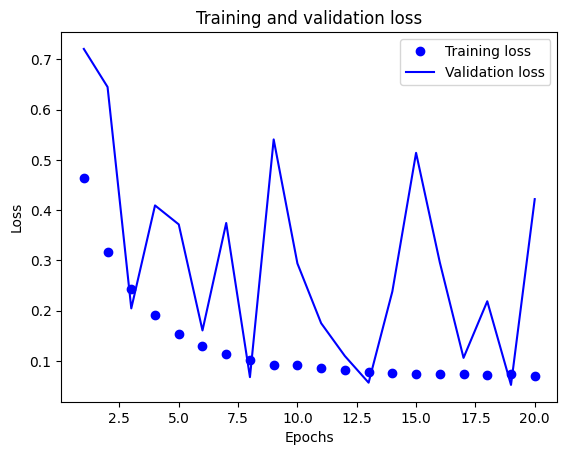

In [75]:
history_plot(test_one)

In [ ]:
cv_data2 = cv_data[1:120]

cv_data2[0:12] = np.array([0,1,2,3,4,5,6,7,8,9,10,11]).reshape([12,1])
output = stat_true_window_cross_val(cv_data2, ['auto_arima','complex_smoothing'], [new_aaPredFunction, new_cesPredFunction])

NameError: name 'cv_data' is not defined

In [ ]:
print(output[0:3,0:13])
print(cv_data[0:12])

In [ ]:
testResultsQQQ, trainSeriesQQQ, testSeriesQQQ = prep_ticker('QQQ')

print(testResultsQQQ.head() )
print(trainSeriesQQQ.head() )
print(testSeriesQQQ.head() )

[*********************100%%**********************]  1 of 1 completed

        Price  auto_arima  dyn_theta  auto_ets  complex_smoothing
0  376.239990           0          0         0                  0
1  377.880005           0          0         0                  0
2  378.390015           0          0         0                  0
3  378.799988           0          0         0                  0
4  379.730011           0          0         0                  0


In [ ]:
testResultsQQQ, trainSeriesQQQ, testSeriesQQQ = prep_ticker('QQQ', model_list = ['auto_arima', 'dyn_theta', 'complex_smoothing'])



NameError: name 'yf' is not defined

In [ ]:
qqqpreds, qqqerrors = stat_test_wrapper(trainSeriesQQQ, testSeriesQQQ, testResultsQQQ, 200, 10)
